
### **Chapter 2: Linear Quadratic Regulator**


In this section, we will provide the implementation of the LQR controller and demonstrate how it can be applied to a specific task (stabilization task). We begin by formulating the finite-horizon discrete-time LQR, where the optimal control policy is computed via backward dynamic programming over a fixed time window. This formulation provides time-varying feedback gains and serves as a natural starting point for understanding the structure of optimal control.

We then transition to the infinite-horizon LQR formulation, which yields a time-invariant feedback gain by solving the algebraic Riccati equation (DARE). This approach is more computationally efficient and widely used in practice when the control objective is to stabilize the system over an indefinite time horizon.

Finally, we conclude by discussing several limitations of the LQR framework, including its reliance on linearized dynamics, quadratic cost assumptions, and not compatible with constraints. These limitations motivate the exploration of more advanced control methods, such as Model Predictive Control (MPC) and reinforcement learning-based approaches.

All the contents are summarized in the table below.  

<table border="1" style="border-collapse: collapse; text-align: center;">
  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 2 Exercise</th>
  </tr>

  <!-- Row group 1 -->
  <tr>
    <td rowspan="2">Finite-horizon LQR</td>
    <td>implement the finite-horizon LQR controller using bellman recursion</td>
  </tr>
  <tr>
    <td>simulation and visualization</td>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="2">Infinite-horizon LQR</td>
    <td>implement the infinite-horizon LQR controller using bellman equation</td>
  </tr>
  <tr>
    <td>simulation and visualization</td>
  </tr>

  <!-- Row group 3 -->
  <tr>
    <td rowspan="1">Influence of hyperparameters in LQR</td>
    <td>analyze the impact of adjusting the weight matrices on system behavior.</td>
  </tr>

  <!-- Row group 4 -->
  <tr>
    <td rowspan="2">Limitationsof LQR</td>
    <td>Limitation 1: linear dynamics and quadratic cost</td>
  </tr>
  <tr>
    <td>Limitation 2: constraint-incompatible</td>
  </tr>

</table>

First, we need to set up our Python environment and import relevant packages.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca

### **Problem setup:**

- Task: start from given initial position $p_0$, to reach a given terget position $p_T$ (Stabilization)

- Slope profile (height $h$ with reference to horizontal displacement $p$):  
   - case 1: zero slope (linear case), $h(p) = c$
   - case 2: constant slope (linear case), $h(p) = \frac{\pi}{18} \cdot p$
   - case 3: varying slope for small disturbances (nonlinear case), $h(p) = 0.1 \cdot cos(18 p)$
   - case 4: varying slope for under actuated case (nonlinear case), $h(p) = \begin{cases} k \cdot sin(3 p), & p \in [- \frac{\pi}{2}, \frac{\pi}{6}] \\ 1, & p \in (-\infty, -\frac{\pi}{2}) \cup (\frac{\pi}{6}, \infty) \end{cases}$

- System dynmaics of 1d mountain car model (in State space representation): 
   - state vector $\bm{x} = [p, v]^T$
   - input vector $u$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} u
   \end{align*}


### **Preparation: define the mountain car environment and the system dynamics**

In the previous exercise, we demonstrated how to define a symbolic function using CasADi symbolic system, inclusive defining the profile over a slope $h(p)$, deriving the conversion formulas between the slope profile $h(p)$ and the inclination angle $\theta(p)$, and establish the system's dynamics. These formulas have already been integrated into the class `Env` and `Dynamics`. In this chapter, we will specify the arguments and instantiate these classes directly to utilize their functionalities.

**Step 1: specify the arguments for class `Env` and instantiate the class**

- To start with the simpler case (also more compatible with LQR), we will initially focus on a linear system in an unconstrained scenario

- Parameters in the task:  
   - case: 1 (linear case)
   
   - initial state: $\bm{x}_0 = [-0.5, 0.0]^T$
   - target state: $\bm{x}_T = [0.6, 0.0]^T$

**Step 2: call function `test_env()` to plot the mountain profile $h(p)$ and curve of inclination angle $\theta(p)$**

**Step 3: specify the arguments for class `Dynmaics` and instantiate the class**



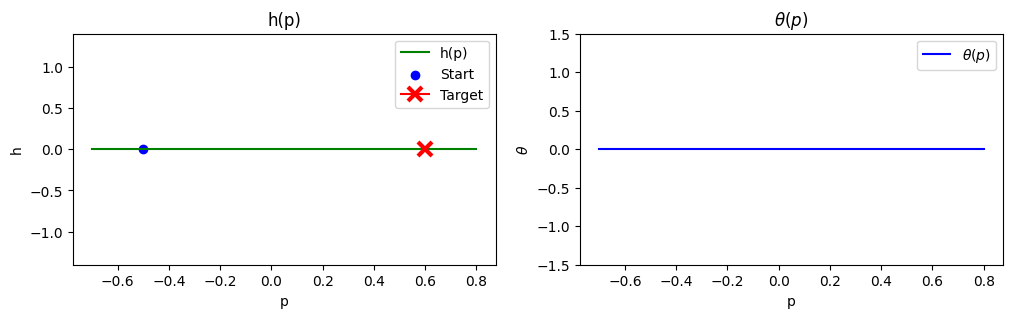

In [2]:
# Define profile of slope, the initial / target state
case = 1 # 1 or 2
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

# Instantiate class 'Env'
# Arguments (without constraints): 
#   1) case: $n \in [1, 2, 3, 4]$, type: int
#   2) initial state: x_0 = [p_0, v_0], type: np.array
#   3) terminal state: x_T = [p_T, v_T], type: np.array
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
env.test_env() #  shape of slope (left side) and theta curve (right side) 

# Instantiate class 'Dynamics'
# Arguments: 
#   1) an object of class `Env`, type: Env  
dynamics = Dynamics(env)

---

### **Part (a): finite-horizon discrete-time LQR controller**

In this section, we will provide the implementation of the finite horizon LQR controller and demonstrate how it can be applied to a specific task (stabilization task). 

**Problem formulation:**

For a linear system:

$$
\bm{x_{k+1}} = \bm{A}_k \bm{x_k} + \bm{B}_k \bm{u_k}
$$

The finite-horizon quadratic cost function is given by:

$$
J(\bm{x_0}) = \sum_{k=0}^{N-1} \bm{u_k}^T \bm{R} \bm{u_k} + \bm{(x_N - x_{ref})}^T \bm{Q}_f \bm{(x_N - x_{ref})}
$$

**Problem solving:**

We solve this problem using **dynamic programming**, starting from the terminal time step \( k = N \) and working backwards to \( k = 0 \).

We define the value function at time $k$ as a quadratic form:

$$
V_k(\bm{x}_k) = (\bm{x}_k - \bm{x}_{\text{ref}})^T \bm{S}_k (\bm{x}_k - \bm{x}_{\text{ref}})
$$

with terminal condition:

$$
\bm{S}_N = \bm{Q}_f
$$

The **Bellman recursion** for backward value function update is given by:

$$
\begin{aligned}
V_k(\bm{x}_k) 
&= \min_{\bm{u}_k} \left[ \bm{u}_k^T \bm{R} \bm{u}_k + V_{k+1}(\bm{x}_{k+1}) \right] \\
&= \min_{\bm{u}_k} \left[ \bm{u}_k^T \bm{R} \bm{u}_k + (\bm{A} \bm{x}_k + \bm{B} \bm{u}_k - \bm{x}_{\text{ref}})^T \bm{S}_{k+1} (\bm{A} \bm{x}_k + \bm{B} \bm{u}_k - \bm{x}_{\text{ref}}) \right]
\end{aligned}
$$

Expanding the above and completing the square yields the optimal control law:

$$
\bm{u}_k^* = -\bm{K}_k (\bm{x}_k - \bm{x}_{\text{ref}})
$$

with time-varying gain matrix:

$$
\bm{K}_k = (\bm{R} + \bm{B}^T \bm{S}_{k+1} \bm{B})^{-1} \bm{B}^T \bm{S}_{k+1} \bm{A}
$$

The Riccati matrix update is:

$$
\bm{S}_k = \bm{A}^T \bm{S}_{k+1} \bm{A} - \bm{A}^T \bm{S}_{k+1} \bm{B} (\bm{R} + \bm{B}^T \bm{S}_{k+1} \bm{B})^{-1} \bm{B}^T \bm{S}_{k+1} \bm{A}
$$

**Step 1: implement the finite horizon LQR controller**  

In this step, we will implement the setup function `setup_external()`, which will be automatically called in the constructor of class `FiniteLQRController`. The implementation will follow three key steps:

1\) Obtain the system matrices: Retrieve the $\bm{A}$ and $\bm{B}$ matrices from the discrete-time system dynamics;  
    Hint: you may use the method `get_linearized_AB_discrete()` from class `Dynamics` to get the discretized system matrices

2\) Calculate the feedback gain $\bm{K}$: Use the computed Hessian $\bm{S}$ to determine the LQR feedback gain $\bm{K}$;  
    Hint: you may use the method `numpy.linalg.inv()` to solve the inverse matrix

3\) Update the Hessian matrix $\bm{S}$ of optimal cost: use riccati recursion to calculate $\bm{S}$ for the last step;  

In [3]:
def setup_external(self) -> None:
        
    # Set up equilibrium state
    self.x_eq = self.target_state

    # Solve input at equilibrium
    self.u_eq = self.dynamics.get_equilibrium_input(self.x_eq)

    # Linearize and discretize the system dynamics at equilibrium
    self.A, self.B = self.dynamics.get_linearized_AB_discrete(
        current_state=self.x_eq, current_input=self.u_eq, dt=self.dt
    )

    # Initialize terminal cost
    S = self.Q.copy()

    # Solve Bellman Recursion from backwards to compute gain matrix
    for k in reversed(range(self.N)):

        K = np.linalg.inv(self.R + self.B.T @ S @ self.B) @ (self.B.T @ S @ self.A)

        self.K_list[k] = K

        S = self.Q + self.A.T @ S @ self.A - self.A.T @ S @ self.B @ K

    if self.verbose:
        print(f"LQR Gain Matrix K: {self.K}")

**Step 2: Bind the defined setup function to the class "FiniteLQRController", and run the simulation to see the performance of controller**  

1\) Bind the defined setup function for DP algorithm `setup_external()` to class `FiniteLQRController`;

2\) Specify the arguments and instantiate the controller class `FiniteLQRController` as `LQR_f`; 

- Parameters in the task:  

    i) weight for state $\bm{Q} = \text{diag}([1, 1])$ (requirement: symmetric, positive semi-definite matrix)  

    ii) weight for input $\bm{R} = [0.1]$ (requirement: symmetric, positive definite matrix)  
    
    iii) control frequency $f = 20$

3\) Instantiate the class `Simulator` and call function `run_simulation()` to generate the simulated state- and input-trajectory;

4\) Instantiate the class `Visualizor`, call function `display_final_results()` and `display_animation()` to show the simulations;


u_eq: 00
Simulation finished, will start plotting


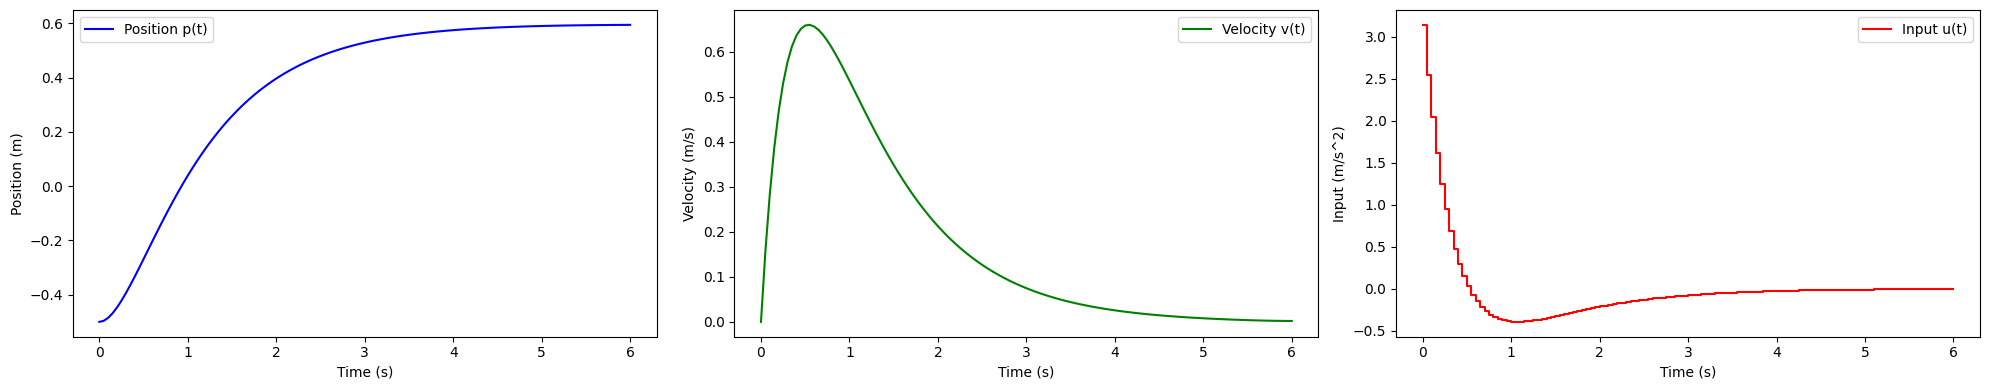

In [4]:
# Bind the defined LQR algorithm to the corresponding class, will be automatically called by constructor
FiniteLQRController.setup = setup_external

# Define weight matrix in stage and terminal cost
Q_f = np.diag([1, 1])
R = np.array([[0.1]])

# Define parameters of simulation
freq = 20 # controll frequency
t_terminal = 6 # time length of simulation
horizon = freq * t_terminal # number of time steps

# Instantiate the finite horizon LQR controller class
# Arguments: 
#   1) an object of class `Env` (to deliver infos about initial state, constraints, etc.), type: Env  
#   2) an object of class `Dynamics` (to deliver infos about symbolic system dynamics), type: Dynamics  
#   3) weight matrices in cost functions: i) `Q`: weight metrix of state, type: np.array  
#                                         ii) `R`: weight metrix of input, type: np.array  
#   4) freq: control frequency $f$ , type: int  
#   5) name: the name of current coltroller displayed in plots, type: string
controller_lqr_f = FiniteLQRController(env, dynamics, Q_f, R, freq, horizon=horizon, name='LQR_f')

# Instantiate the simulator, and then run the simulation
simulator_lqr_f = Simulator(dynamics, controller_lqr_f, env, 1/freq, t_terminal)
simulator_lqr_f.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_lqr_f = Visualizer(simulator_lqr_f)
visualizer_lqr_f.display_plots()
#visualizer_lqr_f.display_animation()

---

### **Part (b): infinite-horizon discrete-time LQR controller**

While the finite-horizon LQR offers greater flexibility by incorporating terminal costs and producing time-varying control gains, it suffers from a key limitation: the solution can only be computed via backward recursion. As a result, the entire control policy must be precomputed before execution, making it unsuitable for online adaptation in most practical scenarios. In this section, we will provide the implementation of the LQR controller and demonstrate how it can be applied to a specific task (stabilization task). We will also show the resulting performance and the effects of using the LQR controller in achieving optimal control.


**Problem formulation:**

For a same linear system formulation:

$$
\bm{x_{k+1}} = \bm{A}_k \bm{x_k} + \bm{B}_k \bm{u_k}
$$

As the horizon length $N$ approaches infinity, the problem converges to the infinite-horizon formulation with time-invariant optimal policy. Then the infinite-horizon quadratic cost function is given by:

$$
J(\bm{x_0}) = \sum_{k=0}^{\infty} \bm{u_k}^T \bm{R} \bm{u_k} + \bm{(x_{\infty} - x_{ref})}^T \bm{Q}_f \bm{(x_{\infty} - x_{ref})}
$$

**Explicit Solution:**

The solution to this problem is obtained by solving the **Discrete Algebraic Riccati Equation (DARE):**

$$
\bm{S} = \bm{Q} + \bm{A}^T \bm{S} \bm{A} - (\bm{A}^T \bm{S} \bm{B})(\bm{R} + \bm{B}^T \bm{S} \bm{B})^{-1} (\bm{B}^T \bm{S} \bm{A})
$$

The optimal feedback control policy is given by:

$$
\bm{u^*} = \bm{K} \bm{(x_k - x_{ref})}, \quad \bm{K} = -\left( \bm{R} + \bm{B}^T \bm{S} \bm{B} \right)^{-1} \left( \bm{B}^T \bm{S} \bm{A} \right)
$$

**Step 1: implement the infinite horizon LQR controller**  

In this step, we will implement the setup function `setup_external()`, which will be automatically called in the constructor of class `LQRController`. The implementation will follow three key steps:

1\) Obtain the system matrices: Retrieve the $\bm{A}$ and $\bm{B}$ matrices from the discrete-time system dynamics;  
    Hint: you may use the method `get_linearized_AB_discrete()` from class `Dynamics` to get the discretized system matrices

2\) Solve for the Hessian matrix $\bm{S}$ of optimal cost: Compute the solution to the Discrete Algebraic Riccati Equation (DARE) to obtain $\bm{S}$;  
    Hint: you may use the method `scipy.linalg.solve_discrete_are()` to solve DARE

3\) Calculate the feedback gain $\bm{K}$: Use the computed Hessian $\bm{S}$ to determine the LQR feedback gain $\bm{K}$;  
    Hint: you may use the method `numpy.linalg.inv()` to solve the inverse matrix

In [5]:
def setup_external(self):

    # Set up equilibrium state
    self.x_eq = self.target_state

    # Solve input at equilibrium
    self.u_eq = self.dynamics.get_equilibrium_input(self.x_eq)

    # Linearize dynamics at equilibrium
    # Hint: use function self.dynamics.get_linearized_AB_discrete
    self.A, self.B = self.dynamics.get_linearized_AB_discrete(
        current_state=np.zeros(self.dim_states), current_input=np.zeros(self.dim_inputs), dt=self.dt
    )

    # Solve DARE to compute gain matrix
    # Hint: use function scipy.linalg.solve_discrete_are
    S = scipy.linalg.solve_discrete_are(self.A, self.B, self.Q, self.R)
    self.K = np.linalg.inv(self.R + self.B.T @ S @ self.B) @ (self.B.T @ S @ self.A)

    # With this LQR gain self.K, the input can be calculate by multiplying the state difference
    # u = self.u_eq - self.K @ (current_state - self.self.x_eq)


**Step 2: Bind the defined setup function to the class "LQRController", and run the simulation to see the performance of controller**  

1\) Bind the defined setup function for DP algorithm `setup_external()` to class `LQRController`;

2\) Specify the arguments and instantiate the controller class `LQRController` as `LQR_0`; 

- Parameters in the task:  

    i) weight for state $\bm{Q} = \text{diag}([1, 1])$ (requirement: symmetric, positive semi-definite matrix)  

    ii) weight for input $\bm{R} = [1]$ (requirement: symmetric, positive definite matrix)  
    
    iii) control frequency $f = 20$

3\) Instantiate the class `Simulator` and call function `run_simulation()` to generate the simulated state- and input-trajectory;

4\) Instantiate the class `Visualizor`, call function `display_final_results()` and `display_animation()` to show the simulations;


u_eq: 00
Simulation finished, will start plotting


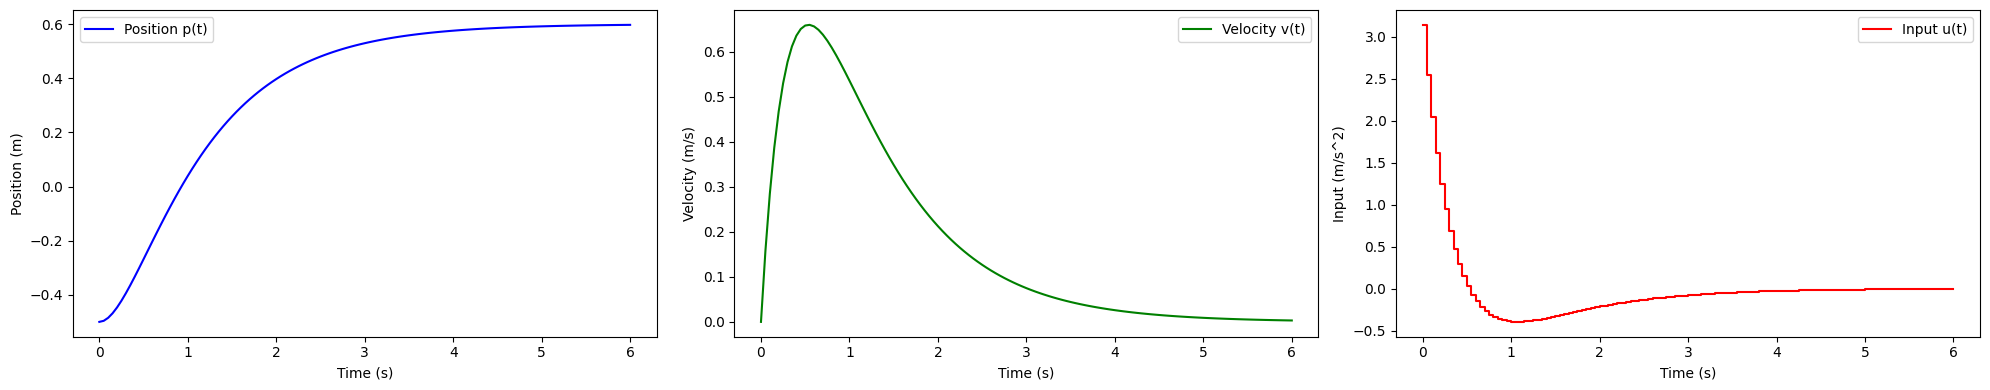

In [6]:
# Bind the defined DP algorithm to the corresponding class, will be automatically called by constructor
LQRController.setup = setup_external

# Define weight matrix in stage and terminal cost
Q_0 = np.diag([1, 1])
R = np.array([[0.1]])

# Define parameters of simulation
freq = 20 # controll frequency
t_terminal = 6 # time length of simulation

# Instantiate the LQR controller class
# Arguments: 
#   1) an object of class `Env` (to deliver infos about initial state, constraints, etc.), type: Env  
#   2) an object of class `Dynamics` (to deliver infos about symbolic system dynamics), type: Dynamics  
#   3) weight matrices in cost functions: i) `Q`: weight metrix of state, type: np.array  
#                                         ii) `R`: weight metrix of input, type: np.array  
#   4) freq: control frequency $f$ , type: int  
#   5) name: the name of current coltroller displayed in plots, type: string
controller_lqr_0 = LQRController(env, dynamics, Q_0, R, freq, name='LQR_0')

# Instantiate the simulator, and then run the simulation
simulator_lqr_0 = Simulator(dynamics, controller_lqr_0, env, 1/freq, t_terminal)
simulator_lqr_0.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_lqr_0 = Visualizer(simulator_lqr_0)
visualizer_lqr_0.display_plots()
#visualizer_lqr_0.display_animation()


---

### **Part (C): Influence of the Weight Matrix on LQR Performance**

In this section, we will analyze how the choice of weight matrices in the cost function affects the performance of the LQR controller. By tuning the weight matrices $\bm{Q}$ (which penalize deviations in state) while keeping $\bm{R}$ (which penalizes control input) fixed, we can observe how the system behaves under different control strategies.

Specifically, we define two LQR controller with different weight matrices: 

- `LQR_1`: $ \quad \bm{Q}_1 = \text{diag}([10, 10]), \quad \bm{R} = [1]$  

- `LQR_2`: $ \quad \bm{Q}_2 = \text{diag}([0.2, 0.2]), \quad \bm{R} = [1]$  

Using these configurations, we simulate the system's response under two LQR controllers (`LQR_1` and `LQR_2`) and and make a contrast with the controller defined in the last step (`LQR_0`). By observing the results, we gain insight into how adjusting the weight matrix influences the controller's aggressiveness and efficiency.

u_eq: 00
Simulation finished, will start plotting
u_eq: 00
Simulation finished, will start plotting


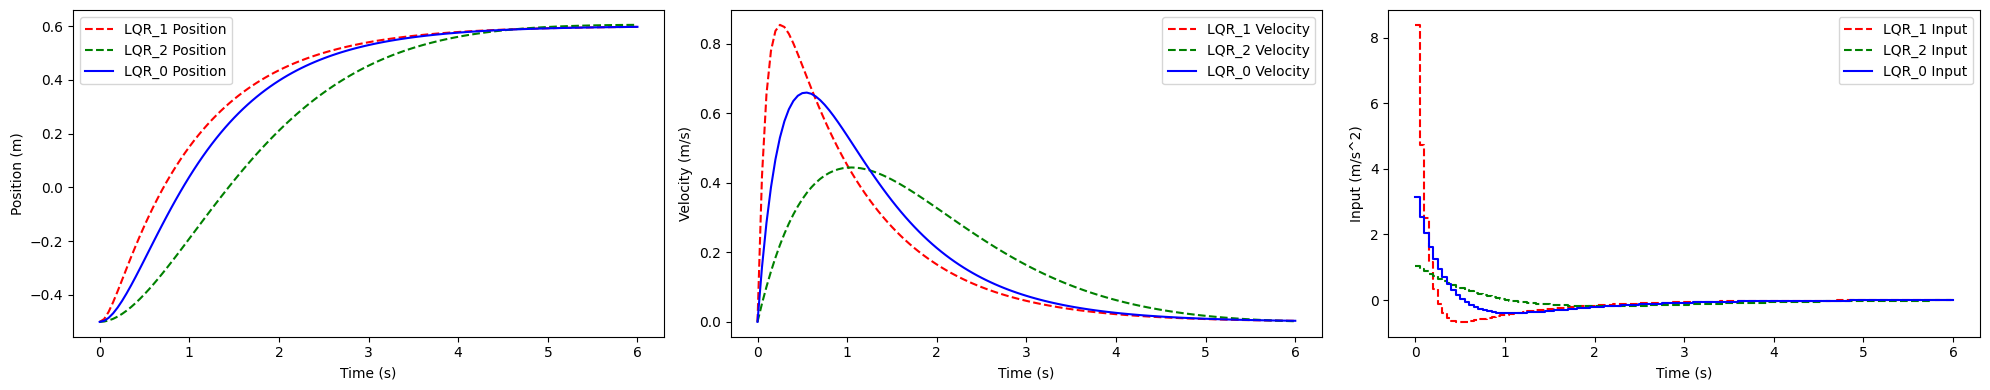

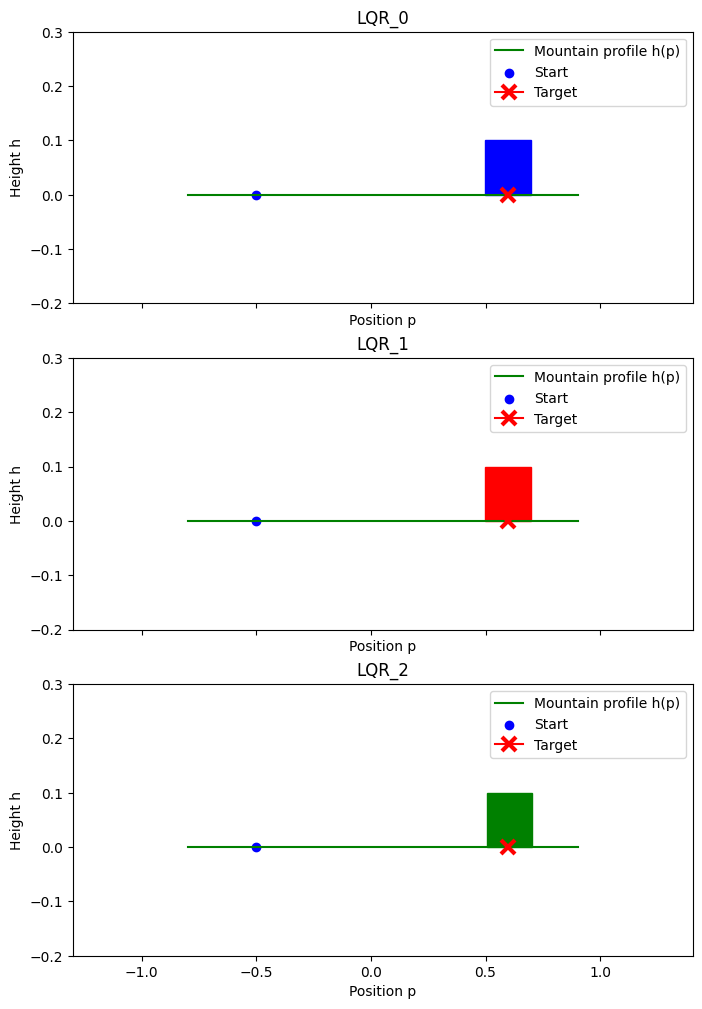

In [7]:
# Define weight matrix in stage and terminal cost
#   for reference: Q_0 = np.diag([1, 1])
Q_1 = np.diag([10, 10])
Q_2 = np.diag([0.1, 0.1])

# Instantiate the LQR controller class, the simulator class, and then run the simulation
controller_lqr_1 = LQRController(env, dynamics, Q_1, R, freq, name='LQR_1')
simulator_lqr_1 = Simulator(dynamics, controller_lqr_1, env, 1/freq, t_terminal)
simulator_lqr_1.run_simulation()

controller_lqr_2 = LQRController(env, dynamics, Q_2, R, freq, name='LQR_2')
simulator_lqr_2 = Simulator(dynamics, controller_lqr_2, env, 1/freq, t_terminal)
simulator_lqr_2.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_lqr_0.display_contrast_plots(simulator_lqr_1, simulator_lqr_2)
visualizer_lqr_0.display_contrast_animation(simulator_lqr_1, simulator_lqr_2)

#### **Results Analysis: Influence of LQR Weight Matrices on System Performance**

The figure above compares the performance of three Linear Quadratic Regulator (LQR) controllers: **LQR_1**, **LQR_2**, and **LQR_0**. Each controller is defined with different weight matrices $\bm{Q}$, which penalize the state deviations, while $\bm{R}$, which penalizes control effort, remains the same.

The comparison clearly demonstrates the impact of the weight matrix $\bm{Q}$ on LQR performance:
1. **Higher $\bm{Q}$** (LQR_1):  
   - Prioritizes minimizing state deviations.  
   - Results in faster convergence but higher control effort.  

2. **Lower $\bm{Q}$** (LQR_2):  
   - Reduces control effort and produces smoother trajectories.  
   - Leads to slower convergence and delayed state correction.  

3. **Moderate $\bm{Q}$** (LQR_0):  
   - Balances control effort and tracking performance.  

The selection of $\bm{Q}$ depends on the system's requirements:  
- For tasks requiring fast convergence, a higher $\bm{Q}$ is appropriate.  
- For energy-constrained systems, a lower $\bm{Q}$ ensures smoother and less aggressive control. 

#### **Main Conclusion:**

By tuning the relative magnitude of weight matrices $\bm{Q}$ and $\bm{R}$, LQR controllers can achieve the desired trade-off between tracking performance and control effort.

*Note 1: Here we have only discussed the effect of $\bm{Q}$. The effect of $\bm{R}$ is inverse, as the controller's behavior is fundamentally influenced by the relative magnitude of $\bm{Q}$ and $\bm{R}$.*

*Note 2: In this example, we use $\bm{Q}$ with eigenvalues equal to $\bm{R}$ as a moderate baseline. However, this choice does not universally apply, as the magnitude of states and inputs depends on their units. But conversely, in the practice it is always important to carefully scale the states and inputs to similar numerical ranges. Otherwise, large discrepancies in the scales of $\bm{Q}$ and $\bm{R}$ can result in an ill-conditioned cost Hessian, causing numerical instability and divergence during optimization.*

---


### **Part (D): Limitations of the LQR Controller**

At last, we want to emphasize the limitations of LQR: 

  1) a **linear dynamics**;  

  2) a **quadratic cost function**;  
  
  3) and operates under **no constraints**;  

While the quadratic cost is well-suited for these assumptions, we will mostly focus on the last 2 requirements.


#### **1. Linear vs. Nonlinear Dynamics**

LQR is designed specifically for **linear systems**, where its optimality is well established. However, in real-world applications, most systems exhibit **nonlinear dynamics**. Directly applying LQR to nonlinear systems can lead to degraded control performance, reduced accuracy, and potential instability. 

In this section, we will explore this limitation through a comparative study. We design two test cases:  

 - `LQR_0`: Using a purely linear system for the dynamics (from case 1 or 2)

 - `LQR_disturbance`: Using a nonlinear system dynamics (from case 3 or 4)

while keeping the same task definitions and cost design as in the linear case. By analyzing the results, we aim to understand how nonlinearity impacts the effectiveness of the LQR controller under identical conditions.  


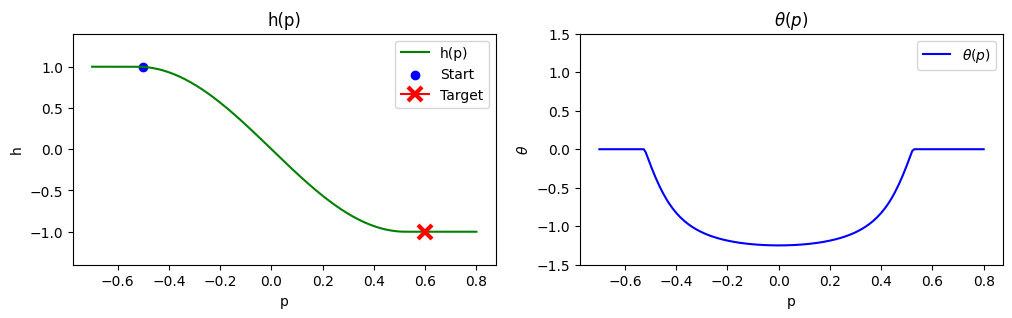

u_eq: 0
Simulation finished, will start plotting


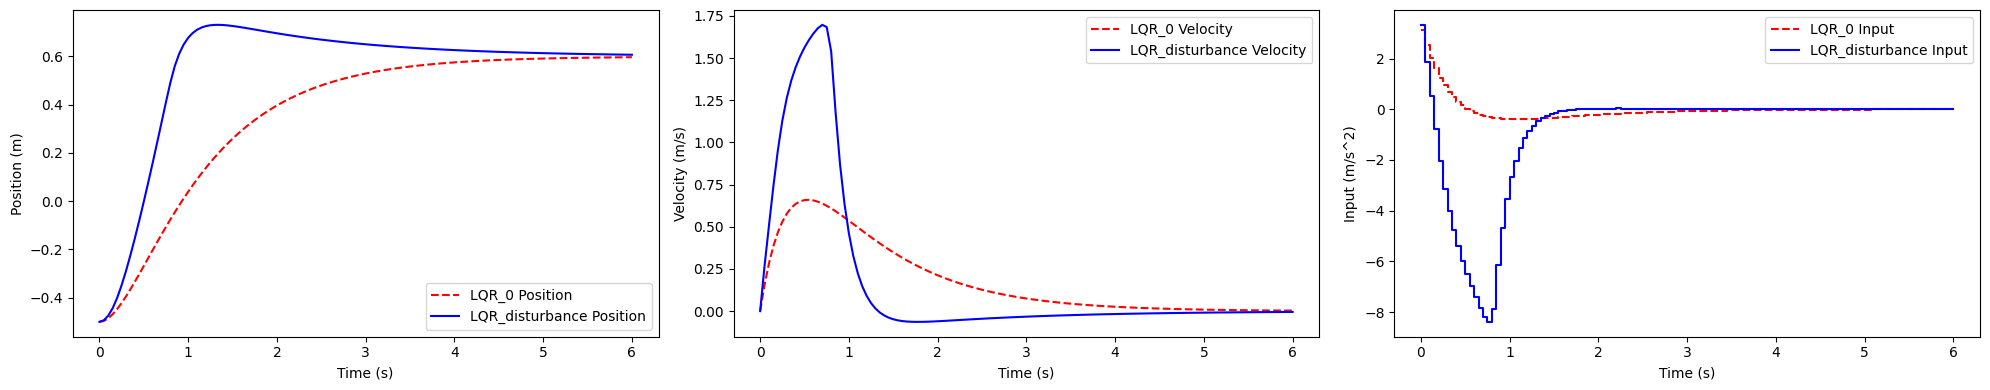

In [8]:
# Define the case
case_disturbance = 3 # 3 or 4

# Instantiate class 'Env' and visualize the shape of the slope (left side) and theta curve (right side) 
env_disturbance = Env(case_disturbance, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
env_disturbance.test_env()

# Instantiate class 'Dynamics'
dynamics_disturbance = Dynamics(env_disturbance)

# Instantiate the LQR controller class
controller_lqr_disturbance = LQRController(env_disturbance, dynamics_disturbance, Q_0, R, freq, name='LQR_disturbance')

# Instantiate the simulator, and then run the simulation
simulator_lqr_disturbance = Simulator(dynamics_disturbance, controller_lqr_disturbance, env_disturbance, 1/freq, t_terminal)
simulator_lqr_disturbance.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_lqr_disturbance = Visualizer(simulator_lqr_disturbance)
visualizer_lqr_disturbance.display_contrast_plots(simulator_lqr_0)
#visualizer_lqr_disturbance.display_contrast_animation(simulator_lqr_0)


#### **Results Analysis: Influence of LQR on Nonlinear Dynamics**

From the results shown in the figure, a significant difference can be observed when applying the LQR control law to a system with nonlinear dynamics versus a linear system:  

- **Nonlinear Dynamics** (`LQR_disturbance`): The system fails to directly stabilize at the target position. Instead, the trajectory exhibits overshoot before gradually returning to the desired state. This behavior arises because the LQR control law, designed for linear systems, cannot fully compensate for the nonlinearities in the dynamics.  

- **Linear Dynamics** (`LQR_0`): The system stabilizes precisely at the target position without overshoot, demonstrating the optimality and precision of LQR under its intended linear assumptions.  

#### **Main Conclusion:**
While sometimes the controller can still stabilize the system, the presence of overshoot and deviations highlights its suboptimal performance when linear assumptions are violated.

*Note: The loss of accuracy in nonlinear systems can be mitigated by applying the **iterative LQR (iLQR)** method (which will be introduced in the next Lecture). The key idea of iLQR is to perform a Taylor expansion of the cost function and dynamics around each operating point, incorporating higher-order derivatives into the optimization process. In fact, LQR can be viewed as a special case of iLQR when the system dynamics are linear.*

---


#### **2. Effect of Input Constraints on LQR Performance**

LQR is formulated under the assumption of **unconstrained inputs**, meaning it does not inherently support input saturation or upper/lower constraints. However, in real-world systems, control inputs such as force, torque, or voltage often have physical limits. When the LQR controller generates control inputs exceeding these limits, the inputs will be **clipped** to the boundaries. This behavior can cause saturation between the actual system trajectory and the ideal trajectory predicted by the LQR controller.

To illustrate this limitation, we design two test scenarios:

- **Ideal LQR Control (`LQR_0`)**:  

   - No constraints are applied to the control inputs

   - The system follows the ideal trajectory predicted by the LQR controller

- **Clipped LQR Control (`LQR_real_traj`)**: 

   - Input constraints are imposed, which means that the input is limited within an upper and lower bound

   - Any control input exceeding these bounds is **clipped**, leading to saturation

u_eq: 00
Simulation finished, will start plotting


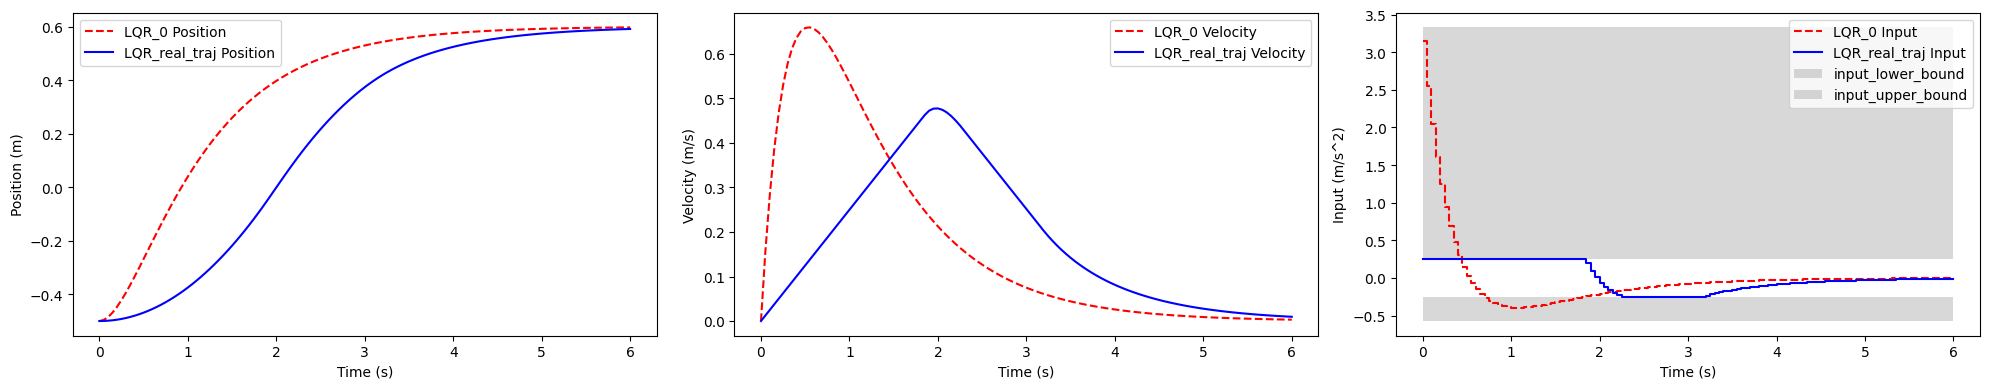

In [9]:
# Define a upper bound of input a
input_ubs = 0.25
input_lbs = -0.25

# Instantiate class 'Env' and visualize the shape of the slope (left side) and theta curve (right side) 
# Arguments (with state / input constraint): 
#   1) case: $n \in [1, 2, 3, 4]$, type: int
#   2) initial state: x_0 = [p_0, v_0], type: np.array
#   3) terminal state: x_T = [p_T, v_T], type: np.array
#   4) constraints on states: i) state_lbs [\underline{p}, \underline{v}], type: np.array or None
#                             ii) state_ubs [\overline{p}, \overline{v}], type: np.array or None
#   5) constraints on input: i) input_lbs \underline{u}, type: float or None
#                            ii) input_ubs \overline{u}, type: float or None
env_input_constraint = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]), 
                           input_lbs=input_lbs, input_ubs=input_ubs)

# Instantiate the LQR controller class
controller_lqr_input_constraint = LQRController(env_input_constraint, dynamics, Q_0, R, freq, name='LQR_real_traj')

# Instantiate the simulator, and then run the simulation
simulator_lqr_input_constraint = Simulator(dynamics, controller_lqr_input_constraint, env_input_constraint, 1/freq, t_terminal)
simulator_lqr_input_constraint.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_lqr_input_constraint = Visualizer(simulator_lqr_input_constraint)
visualizer_lqr_input_constraint.display_contrast_plots(simulator_lqr_0)
#visualizer_lqr_input_constraint.display_contrast_animation(simulator_lqr_0)




#### **Results Analysis**

1. **Input Response**:  
   - In the input plot (right panel), the ideal LQR (red dashed line) generates a continuous and unconstrained input.  
   - However, the constrained LQR (blue solid line) shows clear cut-off behavior, where the input is clipped to the specified upper and lower bounds (gray shaded regions). This results in a flattened profile that deviates from the ideal input.

2. **Position Response**:  
   - In the position plot (left panel), the ideal trajectory (LQR_0, red dashed line) smoothly reaches the target position.  
   - In contrast, the constrained trajectory (LQR_real_traj, blue solid line) shows slower convergence due to input clipping, resulting in noticeable deviations from the ideal trajectory.

This limitation highlights the importance of considering input constraints during controller design. Methods such as **constrained optimal control** or **Model Predictive Control (MPC)** can address this issue by explicitly incorporating input limits into the optimization problem.